In [1]:
#library
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import StandardScaler
from plotnine import *
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

#### READING IN FILES

In [2]:
#read in files
allegations = pd.read_csv("../data/01_allegations.csv")
officers = pd.read_csv("../data/02_police_officers.csv")
complaints = pd.read_csv("../data/03_complaints.csv")
penalties = pd.read_csv("../data/04_penalties.csv")
mpv = pd.read_csv("../data/05_mapping_police_violence.csv")

In [3]:
#dataset sizes
print(allegations.shape)
print(complaints.shape)
print(officers.shape)
print(penalties.shape)
print(mpv.shape)

#note that singular complaints can contain multiple allegations which is why dataframe shapes are different
#individual officers can also be involved in multiple complaints/allegations (repeat offender)
#penalties are only for officers whose charge was substantiated (guilty)

(397206, 18)
(133117, 14)
(92553, 14)
(12865, 13)
(14151, 61)


#### MERGING FILES

In [4]:
#merging inner since multiple allegations should be under singular complaint id
temp = pd.merge(allegations, complaints, on = ["Complaint Id", "As Of Date"], how = "inner")

In [5]:
#checks shape
temp.shape

(397206, 30)

In [6]:
#merging left since penalties are only applied if complaint is substantiated
temp_updated = pd.merge(temp, penalties, on = ["Complaint Id", "As Of Date", "Tax ID"], how = "left")

In [7]:
#checking shape
temp_updated.shape

(397206, 40)

In [8]:
#merge inner since latter dataframe includes all officers on roster, including those who have 0 complaints/allegations
#only keep officers who have complaints
nypd = pd.merge(temp_updated, officers, on = ["As Of Date", "Tax ID"], how = "inner")

In [9]:
#checking shape
nypd.shape

(235939, 52)

In [10]:
#filter mpv for nypd cases and instances where officer name is known 
mpv_filtered = (
    mpv.query("(agency_responsible == 'New York Police Department') & (officer_names.notna())")
    .loc[:, ['officer_names', 'date']]
    .assign(officer_names= lambda df: df["officer_names"]
            .astype(str)
            .str.replace(" and ", ",")
            .str.replace("(both fired weapons)", "")
            .str.split(','))
    .explode('officer_names')
    .reset_index(drop=True)
    .assign(officer_names_lower = lambda df: df['officer_names']
            .str.lower()
            .str.strip())
    .drop_duplicates()
    .assign(in_news = lambda df: 1)
)

In [11]:
#grabbing year
mpv_filtered["year"] = pd.to_datetime(mpv_filtered["date"]).dt.year.astype(int)
mpv_filtered.drop(columns = ["date"], inplace = True)
nypd['year'] = nypd['Incident Date'].str[:4].astype(float).astype('Int64')

In [12]:
#standard nypd names
nypd = (
    nypd.assign(officer_names = nypd["Officer First Name"] + " " + nypd["Officer Last Name"])
    .assign(officer_names_lower = lambda df: df["officer_names"].str.lower().str.strip())
)

In [13]:
#merge nypd and mpv by names
nypd = pd.merge(nypd, mpv_filtered, on = ["officer_names_lower", "officer_names", "year"], how = "left")

#### FILTERING DATASET

In [14]:
#filter data between 2013-2020 -- media coverage data not avalaible for MPV before 2013. Cutoff at 2020 to avoid COVID/BLM
#drops data with missing for year
nypd.dropna(subset=['year'], inplace = True)
nypd = nypd.query("year > 2013 & year < 2020")

C:\Users\helen\AppData\Local\Temp\ipykernel_12888\2215165747.py:4: RuntimeWarning: Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.


In [15]:
#checking shape
nypd.shape

(52408, 56)

In [16]:
nypd["CCRB Complaint Disposition"].unique()

array(['Unsubstantiated', 'Substantiated (Command Discipline B)',
       'Unfounded', 'Exonerated', 'Complaint Withdrawn',
       'Complainant Uncooperative', 'Complainant Unavailable',
       'Substantiated (Command Discipline A)',
       'Alleged Victim Uncooperative',
       'Substantiated (Formalized Training)', 'Substantiated (Charges)',
       'Closed - Pending Litigation', 'Miscellaneous - Subject Retired',
       'Substantiated (Command Lvl Instructions)',
       'Substantiated (Instructions)', 'Alleged Victim Unavailable',
       'Victim Unidentified', 'Miscellaneous - Subject Resigned',
       'Substantiated (Command Discipline)', 'Officer(s) Unidentified',
       'Miscellaneous', 'Unable to Determine',
       'Substantiated (No Recommendations)', 'Witness Uncooperative',
       'Miscellaneous - Subject Terminated', 'Within NYPD Guidelines'],
      dtype=object)

In [17]:
#Recode case outcome options
null_responses = ["Complainant Uncooperative", "Complaint Withdrawn", "Complainant Unavailable", 
                  "Alleged Victim Uncooperative", "Alleged Victim Unavailable", "Miscellaneous - Subject Retired",
                 "Victim Unidentified", "Unable to Determine", "Miscellaneous - Subject Resigned", "Officer(s) Unidentified",
                  "Miscellaneous", "Miscellaneous - Subject Terminated", "Witness Uncooperative", "Closed - Pending Litigation"]
exonerated = ["Within NYPD Guidelines"]
substantiated = [item for item in nypd["CCRB Complaint Disposition"].unique() if item.startswith("Substantiated")]

In [18]:
#recode
nypd['CCRB Complaint Disposition'] = (nypd['CCRB Complaint Disposition'].replace(
        {option: np.nan for option in null_responses}
    ).replace(
        {option:"Exonerated" for option in exonerated}
    ).replace(
        {option:"Substantiated" for option in substantiated}
    )
)

In [19]:
#drops na in case outcomes
nypd.dropna(subset=['CCRB Complaint Disposition'], inplace = True)

In [20]:
#checks shape
nypd.shape

(36666, 56)

In [21]:
#checks discrepancy
nypd["in_news"].value_counts()

in_news
1.0    33
Name: count, dtype: int64

In [22]:
#officer names to query nyt times with (sample of 4000)
#nypd.query("in_news.isnull()")[["officer_names_lower", "year"]].drop_duplicates().sample(4000, random_state=42).to_csv("../data/officer_names.csv", index = False)

In [23]:
#drops useless/redundant columns
nypd.drop(columns = ["As Of Date","Complaint Officer Number", "Officer Rank Abbreviation At Incident", 
                     "Allegation", "Investigator Recommendation","Close Date", "Board Discipline Recommendation", 
                     "Non-APU NYPD Penalty Report Date","APU CCRB Trial Recommended Penalty", "APU Trial Commissioner Recommended Penalty",
                    "APU Plea Agreed Penalty", "APU Case Status", "APU Closing Date", "Officer is_APU",
                    "Current Rank Abbreviation", "Shield No", "Victim / Alleged Victim Race / Ethnicity",
                    "CCRB Allegation Disposition", "NYPD Allegation Disposition", "CCRB Received Date",
                    "CCRB Substantiated Officer Disposition"], inplace = True)

#drops dates, redundant id numbers, cols that abbreviate existing data
#dropped allegation (text description) since FADO type already exists
#drops recommendations since we have exact case outcomes and nypd has final say on penalty
#drops race since legacy race is more appropriate to use in this case (legacy race is for cases before 2022)

#### RECODING VARIABLES

In [24]:
#checking dist
nypd["Victim/Alleged Victim Age Range At Incident"].value_counts()

Victim/Alleged Victim Age Range At Incident
24 < Age <= 29    5469
29 < Age <= 34    5047
20 < Age <= 24    3856
34 < Age <= 39    3703
39 < Age <= 44    2646
44 < Age <= 49    2586
49 < Age <= 54    2220
17 < Age <= 20    1829
54 < Age <= 59    1456
14 < Age <= 17    1270
59 < Age <= 64     655
64 < Age <= 69     440
09 < Age <= 14     413
69 < Age <= 74     227
74 < Age <= 79     123
79 < Age <= 99      64
00 < Age <= 09      34
Name: count, dtype: int64

In [25]:
#new age intervals
under_20 = ['00 < Age <= 09', '09 < Age <= 14', '14 < Age <= 17', '17 < Age <= 20']
age_39_49 = ['39 < Age <= 44', '44 < Age <= 49']
over_49 = ['49 < Age <= 54', '54 < Age <= 59', '59 < Age <= 64','64 < Age <= 69', '69 < Age <= 74', '74 < Age <= 79', '79 < Age <= 99']

In [26]:
#recode age intervals
nypd['Victim/Alleged Victim Age Range At Incident'] = (nypd['Victim/Alleged Victim Age Range At Incident'].replace(
        {option: 'Age <= 20' for option in under_20}
    ).replace(
        {option:'39 < Age <= 49' for option in age_39_49}
    ).replace(
        {option:'Age >= 49' for option in over_49}
    )
)

In [27]:
#checking new dist
nypd["Victim/Alleged Victim Age Range At Incident"].value_counts()

Victim/Alleged Victim Age Range At Incident
24 < Age <= 29    5469
39 < Age <= 49    5232
Age >= 49         5185
29 < Age <= 34    5047
20 < Age <= 24    3856
34 < Age <= 39    3703
Age <= 20         3546
Name: count, dtype: int64

In [28]:
#check dist
nypd["Victim / Alleged Victim Race (Legacy)"].value_counts()

Victim / Alleged Victim Race (Legacy)
Black              16758
Hispanic            7078
White               4022
Unknown             1578
Other Race          1258
Asian                947
Refused              566
American Indian      115
Name: count, dtype: int64

In [29]:
#recode race variables
unknown = ["Unknown", "Other Race", "Refused"]
nypd['Victim / Alleged Victim Race (Legacy)'] = (nypd['Victim / Alleged Victim Race (Legacy)'].replace(
        {option:"Unknown" for option in unknown}
    )
)

In [30]:
#checking new dist
nypd["Victim / Alleged Victim Race (Legacy)"].value_counts()

Victim / Alleged Victim Race (Legacy)
Black              16758
Hispanic            7078
White               4022
Unknown             3402
Asian                947
American Indian      115
Name: count, dtype: int64

In [31]:
#extracting month and dropping var
nypd["month"] = nypd["Incident Date"].str[5:7]
nypd.drop(columns = ["Incident Date"], inplace= True)

In [32]:
#checking dist
nypd["month"].value_counts()

month
08    3487
03    3369
07    3341
06    3310
05    3195
04    3169
10    3029
01    3011
09    2965
02    2845
12    2473
11    2448
__      24
Name: count, dtype: int64

In [33]:
#checking dist
nypd["Location Type Of Incident"].value_counts()

Location Type Of Incident
Street/highway           18878
Apartment/house           7651
Residential building      2137
Police building           2020
NYCHA                     1508
Commercial building       1329
Subway station/train       883
Other                      508
Public space/building      401
Park                       338
Hospital                   244
School                     191
Police vehicle              83
River or waterway           39
Bus                         25
Name: count, dtype: int64

In [34]:
#new categories
residential = ["Apartment/house", "Residential building"]
public_area = ["Police building", "Commercial building", "NYCHA", "Public space/building", "Park", "Hospital", "School"]
in_transit = ["Street/highway", "Bus", "River or waterway", "Police vehicle", "Subway station/train"]

In [35]:
#recoding
nypd["Location Type Of Incident"] = (nypd["Location Type Of Incident"].replace(
        {option:"residential" for option in residential}
    ).replace(
        {option:"public_area" for option in public_area}
    ).replace(
        {option:"transit" for option in in_transit}
    )
)

In [36]:
#checking categories
nypd["Location Type Of Incident"].value_counts()

Location Type Of Incident
transit        19908
residential     9788
public_area     6031
Other            508
Name: count, dtype: int64

In [37]:
#checking categories
nypd["Reason for Police Contact"].value_counts()

Reason for Police Contact
PD suspected C/V of violation/crime - street                  8096
PD suspected C/V of violation/crime - auto                    3090
PD suspected C/V of violation/crime - bldg                    2658
Moving violation                                              2380
Other                                                         2326
Report of other crime                                         2060
Report-dispute                                                1883
Execution of search warrant                                   1634
Other violation of VTL                                        1532
Report-domestic dispute                                       1494
EDP aided case                                                1243
Execution of arrest/bench warrant                             1135
PD suspected C/V of violation/crime - subway                   751
Parking violation                                              682
C/V requested investigation of crime

In [38]:
#recode missing
nypd["Reason for Police Contact"] = nypd["Reason for Police Contact"].apply(lambda x: "Missing" if pd.isnull(x) else x)

In [39]:
#new categories
crime_suspect = [item for item in nypd["Reason for Police Contact"].unique() if item.startswith("PD suspected C/V of violation/crime")]
cv_initiated = [item for item in nypd["Reason for Police Contact"].unique() if item.startswith("C/V")]
report = [item for item in nypd["Reason for Police Contact"].unique() if item.startswith("Report")]
execution = [item for item in nypd["Reason for Police Contact"].unique() if "Execution" in item]
violation = [item for item in nypd["Reason for Police Contact"].unique() if "violation" in item]
aid = [item for item in nypd["Reason for Police Contact"].unique() if "aided" in item or "Aided" in item or "Assist" in item]

In [40]:
#create set of all categories already used
recode_list = [crime_suspect, cv_initiated, report, execution, violation, aid]
flat_list = {item for sublist in recode_list for item in sublist}

In [41]:
#list of categories that haven't been assigned
other_list = [item for item in nypd["Reason for Police Contact"].unique() if item not in flat_list and item != "Missing"]

In [42]:
#recode
nypd["Reason for Police Contact"] = (nypd["Reason for Police Contact"].replace(
        {option:"Suspect of Crime" for option in crime_suspect}
    ).replace(
        {option:"C/V involved" for option in cv_initiated}
    ).replace(
        {option:"Report" for option in report}
    ).replace(
        {option:np.nan for option in "Missing"}
    ).replace(
        {option:"Executed Action" for option in execution}
    ).replace(
        {option:"Violation" for option in violation}
    ).replace(
        {option:"Aid" for option in aid}
    ).replace(
        {option:"Other" for option in other_list}
    ).replace(
        {option:np.nan for option in ["Missing"]}
    )
)

In [43]:
#check new dist
nypd["Reason for Police Contact"].value_counts()

Reason for Police Contact
Suspect of Crime    14595
Report               6703
Violation            4594
Other                3291
Executed Action      2769
C/V involved         2471
Aid                  2056
Name: count, dtype: int64

In [44]:
#check dist
nypd["Outcome Of Police Encounter"].value_counts()

Outcome Of Police Encounter
No arrest made or summons issued        14256
Arrest - other violation/crime          13552
Summons - other violation/crime          1991
Arrest - resisting arrest                1847
Moving violation summons issued          1135
Summons - disorderly conduct             1019
Arrest - assault (against a PO)           831
Other VTL violation summons issued        657
Arrest - disorderly conduct               449
Parking summons issued                    366
Arrest - OGA                              263
Juvenile Report                           140
Arrest - harrassment (against a PO)         8
Summons - harrassment (against a PO)        2
Name: count, dtype: int64

In [45]:
#code missing and new categories
nypd["Outcome Of Police Encounter"] = nypd["Outcome Of Police Encounter"].apply(lambda x: "Missing" if pd.isnull(x) else x)
arrest = [item for item in nypd["Outcome Of Police Encounter"].unique() if item.startswith("Arrest")]
summons = [item for item in nypd["Outcome Of Police Encounter"].unique() if ("Summons" in item or "summons" in item) and item != "No arrest made or summons issued"]

In [46]:
#recode
nypd["Outcome Of Police Encounter"] = (nypd["Outcome Of Police Encounter"].replace(
        {option:"Arrest" for option in arrest}
    ).replace(
        {option:"Summons" for option in summons}
    ).replace(
        {option:np.nan for option in ["Missing"]}
    )
)

In [47]:
#grab year and drop variables
nypd["Last Reported Active Year"] = pd.to_datetime(nypd["Last Reported Active Date"]).dt.year
nypd.drop(columns = ["Last Reported Active Date"], inplace = True)

In [48]:
#new var to see if rank has changed
nypd["Rank Changed"] = np.where(nypd["Current Rank"] == nypd["Officer Rank At Incident"], 0, 1)

In [49]:
#new var to see if command has changed
nypd["Command Changed"] = np.where(nypd["Current Command"] == nypd["Officer Command At Incident"], 0, 1)

In [50]:
#dist
nypd["Total Complaints"].value_counts()

Total Complaints
3     4331
2     4158
4     3700
5     3310
1     3298
6     2850
7     2651
8     2102
9     1719
11    1224
10    1215
12     978
13     830
14     730
16     564
15     540
17     382
19     335
20     330
18     270
21     191
23     120
26     118
28     101
31      93
22      92
29      69
40      62
25      61
24      59
34      57
41      47
27      43
32      17
35      16
39       2
30       1
Name: count, dtype: int64

In [51]:
#list of penalities
nypd["NYPD Officer Penalty"].unique().tolist()

[nan,
 'Command Discipline - A',
 'Formalized Training',
 'Vacation: 10 days',
 'Instructions',
 'Forfeit vacation 18 days',
 'Forfeit vacation 2 days',
 'No penalty',
 'Closed Administratively (No penalty reported)',
 'Command Discipline - B',
 'Forfeit vacation 7 days',
 'Forfeit vacation 3 days / Command Discipline A',
 'Forfeit vacation 25 days',
 'Forfeit vacation 10 days',
 'Suspension: 30 days / Vacation: 25 days / Dismissal Probation 360 days',
 'APU - Decision Pending',
 'Forfeit vacation 20 days',
 'Forfeit vacation 30 days',
 'Forfeit vacation 15 days',
 'Forfeit vacation 5 days',
 'Retired',
 'Formalized Training / Command Level Instructions',
 'Forfeit vacation 8 days',
 'Forfeit vacation 2 days / Command Discipline A',
 'Forfeit vacation 4 days',
 'Dismissal Probation / Forfeit vacation 15 days',
 'Vacation: 25 days',
 'Forfeit vacation 5 days / Command Discipline A',
 'Command Discipline A',
 'Resigned',
 'Dismissal Probation 365 days / Suspension 30 days / Forfeit vacat

In [52]:
#featuring capturing if more than 1 penalty
nypd["PenaltyCount"] = np.where(nypd["NYPD Officer Penalty"].str.contains("/", case=False, na=False), "2+", "1") #2 = more than 1, 1 = 1 penalty
nypd["PenaltyCount"] = np.where(nypd["NYPD Officer Penalty"].str.contains("No penalty", case=False, na=False), "0", nypd["PenaltyCount"])
nypd["PenaltyCount"] = np.where(nypd["NYPD Officer Penalty"].isna(), "Not Applicable", nypd["PenaltyCount"])

In [53]:
#check dist
nypd["PenaltyCount"].value_counts()

PenaltyCount
Not Applicable    27541
1                  7627
0                  1202
2+                  296
Name: count, dtype: int64

In [54]:
#initiate empty new col for penalty recoded
nypd["PenaltyRecoded"] = np.nan

In [55]:
#dummy code all penalties
nypd["NYPD Officer Penalty_Vacation Loss"] = np.where(nypd["NYPD Officer Penalty"].str.contains("vacation", case=False, na=False), 1, 0)
nypd["NYPD Officer Penalty_Command Discipline A"] = np.where(nypd["NYPD Officer Penalty"].str.contains("Command Discipline - A", case=False, na=False), 1, 0)
nypd["NYPD Officer Penalty_Command Discipline B"] = np.where(nypd["NYPD Officer Penalty"].str.contains("Command Discipline - B", case=False, na=False), 1, 0)
nypd["NYPD Officer Penalty_Formalized Training"] = np.where(nypd["NYPD Officer Penalty"].str.contains("Formalized Training", case=False, na=False), 1, 0)
nypd["NYPD Officer Penalty_Instructions"] = np.where(nypd["NYPD Officer Penalty"].str.contains("Instructions|Command Level Instructions", case=False, na=False), 1, 0)
nypd["NYPD Officer Penalty_None"] = np.where(nypd["NYPD Officer Penalty"].str.contains("No penalty", case=False, na=False), 1, 0)
nypd["NYPD Officer Penalty_Left"] = np.where(nypd["NYPD Officer Penalty"].str.contains("Resigned|Terminated|Retired|Dismissed", case=False, na=False), 1, 0)
nypd["NYPD Officer Penalty_Other"] = np.where(nypd["NYPD Officer Penalty"].str.contains("Reprimand|Warned and admonished|Probation|Suspension", case=False, na=False), 1, 0)

In [56]:
#recode penalty to most severe penalty
nypd["PenaltyRecoded"] = np.where(nypd["NYPD Officer Penalty_None"] == 1, "No Penalty", nypd["PenaltyRecoded"])
nypd["PenaltyRecoded"] = np.where(nypd["NYPD Officer Penalty_Instructions"] == 1, "Instructions", nypd["PenaltyRecoded"])
nypd["PenaltyRecoded"] = np.where(nypd["NYPD Officer Penalty_Formalized Training"] == 1, "Formalized Training", nypd["PenaltyRecoded"])
nypd["PenaltyRecoded"] = np.where(nypd["NYPD Officer Penalty_Other"] == 1, "Other", nypd["PenaltyRecoded"])
nypd["PenaltyRecoded"] = np.where(nypd["NYPD Officer Penalty_Vacation Loss"] == 1, "Vacation Loss", nypd["PenaltyRecoded"])
nypd["PenaltyRecoded"] = np.where(nypd["NYPD Officer Penalty_Command Discipline A"] == 1, "Command Discipline A", nypd["PenaltyRecoded"])
nypd["PenaltyRecoded"] = np.where(nypd["NYPD Officer Penalty_Command Discipline B"] == 1, "Command Discipline B", nypd["PenaltyRecoded"])
nypd["PenaltyRecoded"] = np.where(nypd["NYPD Officer Penalty_Left"] == 1, "Other", nypd["PenaltyRecoded"])
nypd["PenaltyRecoded"] = np.where(nypd["PenaltyRecoded"] == "nan", "Not Applicable", nypd["PenaltyRecoded"] )

In [57]:
#check dist
nypd["PenaltyRecoded"].value_counts()

PenaltyRecoded
Not Applicable          27756
Formalized Training      2530
Command Discipline A     1794
Instructions             1409
No Penalty               1202
Vacation Loss            1180
Command Discipline B      507
Other                     288
Name: count, dtype: int64

In [58]:
#drop cols
nypd_penalty_cols = [col for col in nypd.columns if "NYPD Officer Penalty" in col]
nypd = nypd.drop(columns = nypd_penalty_cols)

In [59]:
#normalize total complaints
scaler = StandardScaler()
nypd['Total Complaints_z_score'] = scaler.fit_transform(nypd[['Total Complaints']])

In [60]:
#check dist
nypd["Total Substantiated Complaints"].value_counts()

Total Substantiated Complaints
0     15726
1     10758
2      4978
3      2378
4      1178
5       688
7       288
6       250
8       182
9       138
13       61
10       25
16       16
Name: count, dtype: int64

In [61]:
#normalize total substantiated complaints
scaler = StandardScaler()
nypd['Total Substantiated Complaints_z_score'] = scaler.fit_transform(nypd[['Total Substantiated Complaints']])

In [62]:
#normalize days on force
scaler = StandardScaler()
nypd["Officer Days On Force At Incident_zscore"] = scaler.fit_transform(nypd[["Officer Days On Force At Incident"]])

In [63]:
#drops unnormalized org cols
nypd = nypd.drop(columns = ["Total Complaints", "Total Substantiated Complaints", "Officer Days On Force At Incident"])

#### Adding the NYT Data (Preliminary)

In [64]:
#reading in nyt results
nyt = pd.read_csv("../data/nyt_api_results.csv")

In [65]:
#shape of data
nyt.shape

(4000, 3)

In [66]:
#merge data, grabbing only the officers/years and associated allegations/complaints
nypd_nyt = pd.merge(nypd, nyt, on = ["officer_names_lower", "year"], how = "right")

In [67]:
#checking shape
nypd_nyt.shape

(10322, 39)

In [68]:
#check target dist
nypd_nyt["CCRB Complaint Disposition"].value_counts()

CCRB Complaint Disposition
Unsubstantiated    4994
Substantiated      3720
Exonerated          992
Unfounded           616
Name: count, dtype: int64

In [69]:
#add to in_news
nypd_nyt["in_news"] = np.where(nypd_nyt["news_hits"] > 0, 1, nypd_nyt["in_news"])

In [70]:
#check counts
nypd_nyt["in_news"].value_counts()

in_news
1.0    201
Name: count, dtype: int64

#### Feature Engineering

In [71]:
#create function to check past cases
def check_record(taxid, yr, cat):
    """
    checks the record of each officer for 
    time since last cases, penalties, etc
    """
    officer_df = nypd_nyt[(nypd_nyt['Tax ID'] == taxid) & (nypd_nyt['year'] != yr)][["year", "CCRB Complaint Disposition", "PenaltyRecoded"]]
    min_val = yr - 2
    
    if cat == "case": #looks at if there was a recent complaint
        check = officer_df['year'].tolist() >= min_val
        #returns 1 if recent, 0 otherwise
        if sum(check) > 0:
            return 1
        else:
            return 0
        
    elif cat == "outcome": #looks at if there was a recent substantiated case
        check = officer_df[(officer_df['year'] >= min_val) & (officer_df["CCRB Complaint Disposition"] == "Substantiated")]
        #returns 1 if recent, 0 otherwise
        if len(check) > 0:
            return 1
        else:
            return 0
    
    elif cat == "penalty": #looks if there was a recent case with penalty
        check = officer_df[(officer_df['year'] >= min_val) & (officer_df["PenaltyRecoded"] != "No penalty") & (officer_df["PenaltyRecoded"] != "Not Applicable")]
        #returns 1 if recent, 0 otherwise
        if len(check) > 0:
            return 1
        else:
            return 0

In [72]:
#empty cols
nypd_nyt["recent_prev_case"] = np.nan
nypd_nyt["recent_prev_subs"]= np.nan
nypd_nyt["recent_prev_penalty"]= np.nan

In [73]:
#create variables
for i in range(len(nypd_nyt)):
    taxid = nypd_nyt.loc[i, 'Tax ID']
    yr = nypd_nyt.loc[i, 'year']
    
    nypd_nyt.loc[i, 'recent_prev_case'] = check_record(taxid, yr, "case")
    nypd_nyt.loc[i, "recent_prev_subs"] = check_record(taxid, yr, "outcome")
    nypd_nyt.loc[i, "recent_prev_penalty"] = check_record(taxid, yr, "penalty")

In [74]:
#check dist
nypd_nyt['recent_prev_case'].value_counts()

recent_prev_case
0.0    8341
1.0    1981
Name: count, dtype: int64

In [75]:
nypd_nyt['recent_prev_subs'].value_counts()

recent_prev_subs
0.0    9520
1.0     802
Name: count, dtype: int64

In [76]:
nypd_nyt['recent_prev_penalty'].value_counts()

recent_prev_penalty
0.0    9812
1.0     510
Name: count, dtype: int64

#### Descriptives

In [77]:
nypd_nyt["CCRB Complaint Disposition"].value_counts().reset_index()

,CCRB Complaint Disposition,count
0,Unsubstantiated,4994
1,Substantiated,3720
2,Exonerated,992
3,Unfounded,616


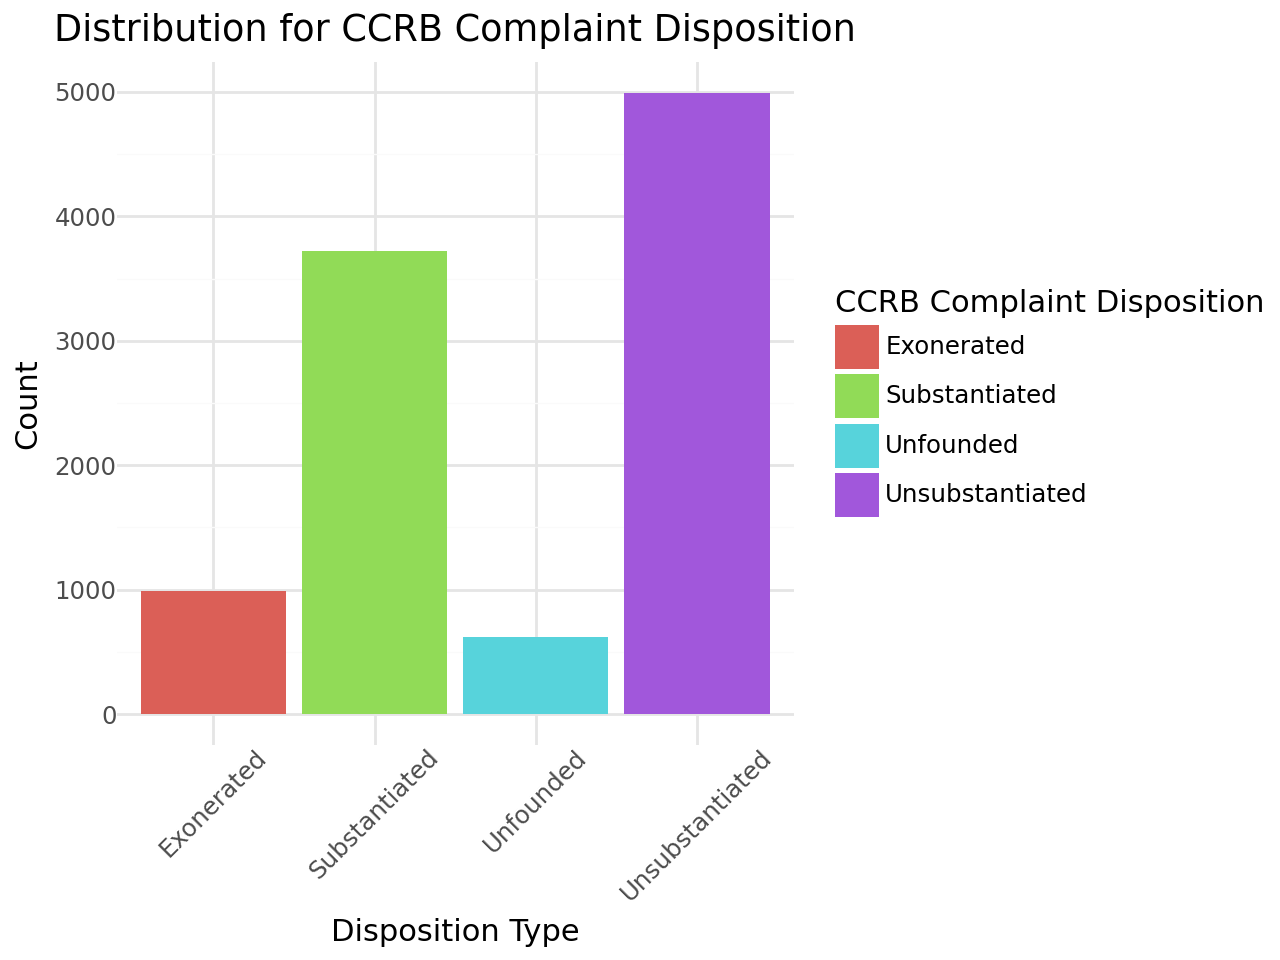

In [78]:
(
ggplot(data = nypd_nyt["CCRB Complaint Disposition"].value_counts().reset_index()) +
    geom_col(aes(x = "CCRB Complaint Disposition", 
                 y = "count", 
                fill = "CCRB Complaint Disposition")) +
    labs(title = "Distribution for CCRB Complaint Disposition",
        x = "Disposition Type",
        y = "Count") +
    theme_minimal() +
    theme(axis_text_x = element_text(angle = 45)) 

)

In [79]:
nypd_nyt["PenaltyRecoded"].value_counts().reset_index()

,PenaltyRecoded,count
0,Not Applicable,7783
1,Formalized Training,671
2,Command Discipline A,558
3,Instructions,430
4,No Penalty,371
5,Vacation Loss,305
6,Command Discipline B,146
7,Other,58


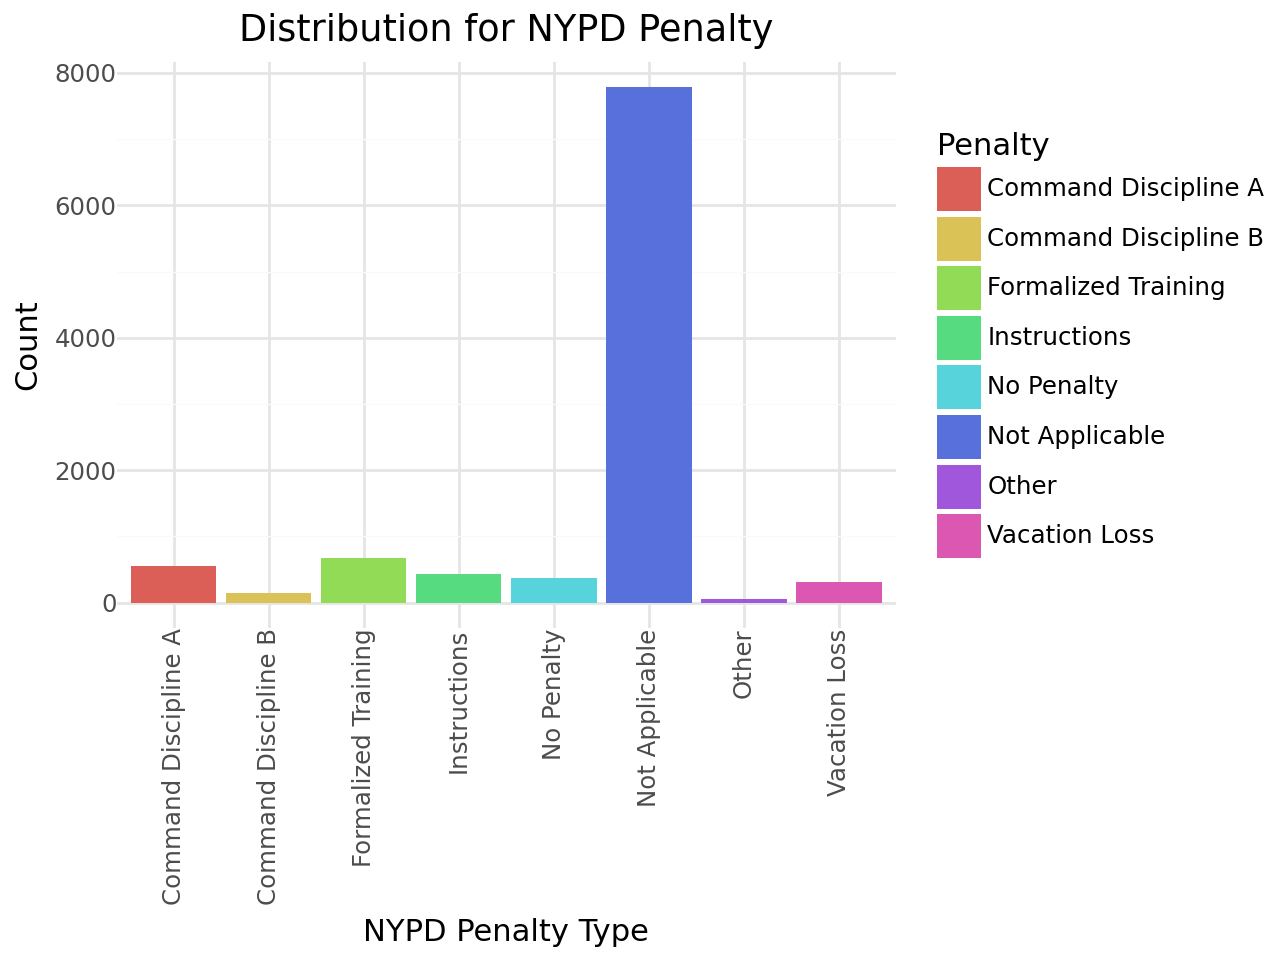

In [80]:
(
ggplot(data = nypd_nyt["PenaltyRecoded"].value_counts().reset_index()) +
    geom_col(aes(x = "PenaltyRecoded", 
                 y = "count", 
                fill = "PenaltyRecoded")) +
    labs(title = "Distribution for NYPD Penalty",
        x = "NYPD Penalty Type",
        y = "Count",
        fill = "Penalty") +
    theme_minimal() +
    theme(axis_text_x = element_text(angle = 90))

)

In [81]:
nypd_nyt["PenaltyCount"].value_counts().reset_index()

,PenaltyCount,count
0,Not Applicable,7731
1,1,2147
2,0,371
3,2+,73


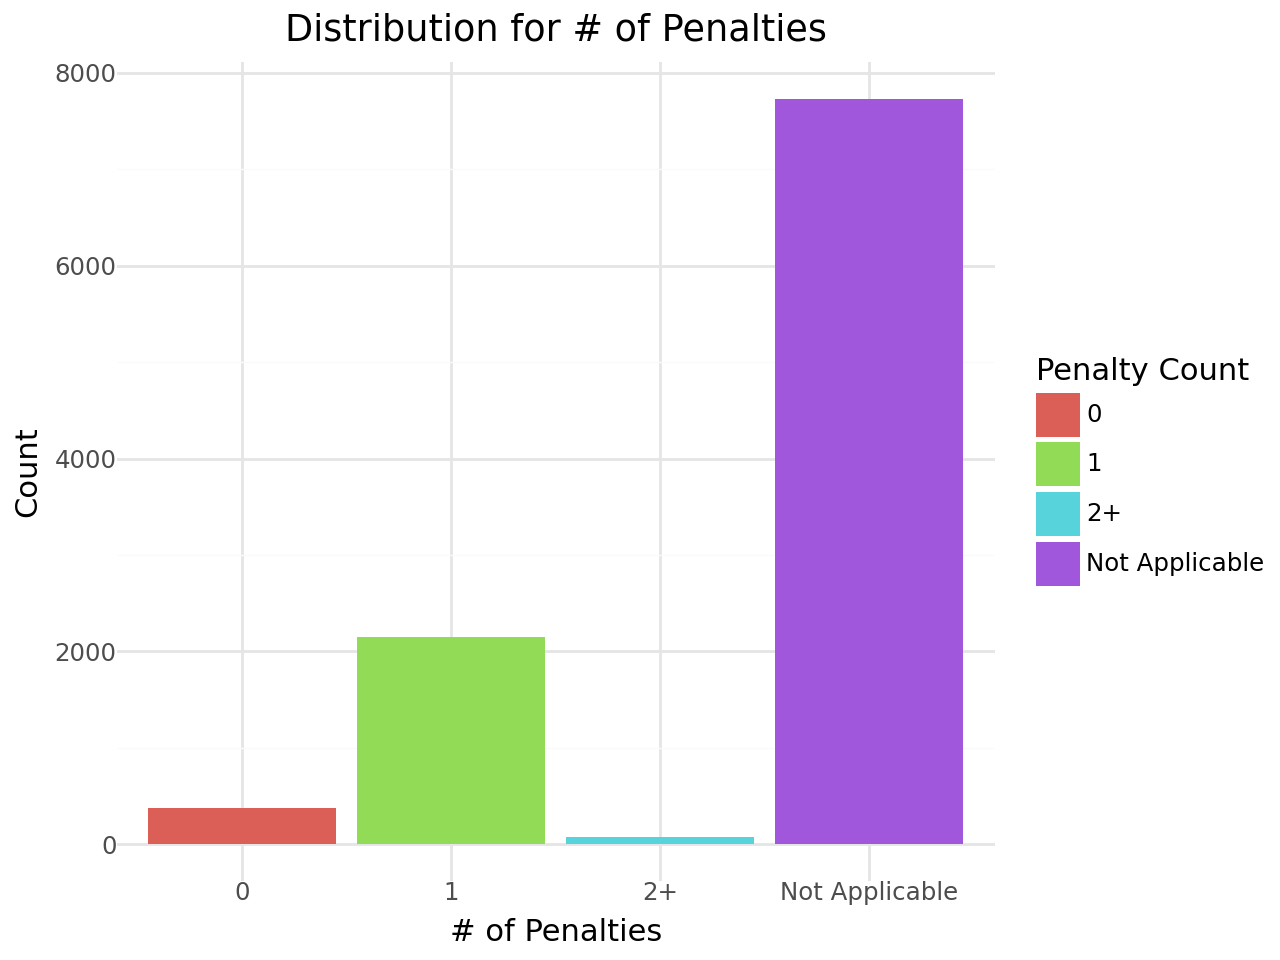

In [82]:
(
ggplot(data = nypd_nyt["PenaltyCount"].value_counts().reset_index()) +
    geom_col(aes(x = "PenaltyCount", 
                 y = "count", 
                fill = "PenaltyCount")) +
    theme_minimal() +
    labs(title = "Distribution for # of Penalties",
        x = "# of Penalties",
        y = "Count",
        fill = "Penalty Count") 

)

#### Dummy Coding

In [83]:
#drop string cols that aren't useful
nypd_nyt.drop(columns = ['Officer Command At Incident', 
                         'Officer First Name', 
                         'Officer Last Name', 
                         'Current Command', 
                         'officer_names', 
                         'officer_names_lower', 
                         'Complaint Id',  
                         'Tax ID',
                         'Allegation Record Identity'], inplace = True)

In [84]:
#cols to dummy code
cols_to_dummy = ['Officer Rank At Incident','FADO Type', 'Victim/Alleged Victim Age Range At Incident',
       'Victim/Alleged Victim Gender', 'Victim / Alleged Victim Race (Legacy)','Borough Of Incident Occurrence',
                'Location Type Of Incident', 'Reason for Police Contact', 'Outcome Of Police Encounter','BWC Evidence', 'Video Evidence',
       'Active Per Last Reported Status', 'Officer Race', 'Officer Gender', 'Current Rank']

In [85]:
#dummy code and add to dataframe
dummy_cols = pd.get_dummies(nypd_nyt[cols_to_dummy], dtype = int)
nypd_nyt = pd.concat([nypd_nyt, dummy_cols], axis=1).drop(columns = cols_to_dummy)

In [86]:
#fill missing with 0
nypd_nyt["in_news"] = nypd_nyt["in_news"].fillna(0)

In [87]:
#convert strings to int
nypd_nyt['Precinct Of Incident Occurrence'] = nypd_nyt['Precinct Of Incident Occurrence'].fillna(1000).astype(int).replace(1000, np.nan)
nypd_nyt['month'] = nypd_nyt['month'].replace("__", 0).astype(int).replace(0, np.nan)

In [88]:
#checks for missing values
nypd_nyt.isnull().mean()[nypd_nyt.isnull().mean() > 0]

Incident Hour                      0.004263
Precinct Of Incident Occurrence    0.017729
month                              0.001453
dtype: float64

In [89]:
#initializing
imputer = IterativeImputer(max_iter = 50, random_state = 42, verbose = 1)

In [90]:
#extracting target
target = nypd_nyt[["CCRB Complaint Disposition", "PenaltyRecoded", "PenaltyCount"]]
temp = nypd_nyt.drop(columns = ["CCRB Complaint Disposition", "PenaltyRecoded", "PenaltyCount"])

In [91]:
#imputing missing data
nypd_nyt_imputed = pd.DataFrame(imputer.fit_transform(temp), columns=temp.columns)

[IterativeImputer] Completing matrix with shape (10322, 87)
[IterativeImputer] Change: 63.52419191932626, scaled tolerance: 2.025 
[IterativeImputer] Change: 0.12969909590219686, scaled tolerance: 2.025 
[IterativeImputer] Early stopping criterion reached.


In [92]:
nypd_nyt_imputed = pd.concat([nypd_nyt_imputed, target], axis = 1)

#### Export

In [93]:
#exporting preprocessed result
nypd_nyt_imputed.to_csv("../data/cleaned_data.csv", index = False)